#1. Downloading and Importing dependencies and Libraries

In [1]:
!pip install -U transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 367.1 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

In [2]:
!pip install tensorboard

In [3]:
import matplotlib.pyplot as plt
import evaluate
import glob
from datasets import load_dataset
import numpy as np
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)

In [20]:
import torch
device = 0 if torch.cuda.is_available() else -1
device

0

#2. Downloading huggingface dataset for patents classification

Patent textual data contains 9 classes, 35k Patents and abstracts divided into 3 splits: train (25k), val (5k) and test (5k) taken from [hugging face](https://huggingface.co/datasets/ccdv/patent-classification)

In [4]:
train_dataset = load_dataset("ccdv/patent-classification", split='train')
valid_dataset = load_dataset("ccdv/patent-classification", split='validation')
test_dataset = load_dataset("ccdv/patent-classification", split='test')
print(train_dataset)
print(valid_dataset)
print(test_dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for ccdv/patent-classification contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ccdv/patent-classification.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 5000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 5000
})


In [5]:
# Visualize a sample.
train_dataset[0]

{'text': 'turning now to the drawings , there is shown in fig1 an integrated circuit continuity testing system in which a specimen or circuit configuration 16 is mounted on a fixture 18 operable to vibrate the specimen under controlled conditions , e . g . sinusoidally , randomly , or a combination of the two . the specific structure of the fixture and the means for vibrating it are known in the art and thus not further discussed . the specimen and fixture are housed in a closed chamber 20 whereby the specimen under test can be subjected to temperature cycling , either alone or in conjunction with the vibration testing . an environmental control apparatus , indicated at 22 , is provided for selectively heating or cooling the chamber interior . a cable 24 electrically connects fixture 18 , and thus specimen 16 , with a continuity testing board 26 . it is to be understood that cable 24 includes a multiplicity of separate electrical connections between fixture 18 and testing board 26 , th

In [ ]:
# Dataset labels cMapping

In [6]:
unique_labels = set()

for example in train_dataset:
    unique_labels.add(example['label'])
for example in valid_dataset:
    unique_labels.add(example['label'])
for example in test_dataset:
    unique_labels.add(example['label'])

# Print all unique labels
print("Unique labels:")
print(unique_labels)

Unique labels:
{0, 1, 2, 3, 4, 5, 6, 7, 8}


In [7]:
# Creating id2label mapping
id2label = {
    0: "Human Necessities",
    1: "Performing Operations; Transporting",
    2: "Chemistry; Metallurgy",
    3: "Textiles; Paper",
    4: "Fixed Constructions",
    5: "Mechanical Engineering; Lightning; Heating; Weapons; Blasting",
    6: "Physics",
    7: "Electricity",
    8: "General tagging of new or cross-sectional technology"
}

# Creating label2id mapping
label2id = {v: k for k, v in id2label.items()}

print("id2label:", id2label)
print("label2id:", label2id)

id2label: {0: 'Human Necessities', 1: 'Performing Operations; Transporting', 2: 'Chemistry; Metallurgy', 3: 'Textiles; Paper', 4: 'Fixed Constructions', 5: 'Mechanical Engineering; Lightning; Heating; Weapons; Blasting', 6: 'Physics', 7: 'Electricity', 8: 'General tagging of new or cross-sectional technology'}
label2id: {'Human Necessities': 0, 'Performing Operations; Transporting': 1, 'Chemistry; Metallurgy': 2, 'Textiles; Paper': 3, 'Fixed Constructions': 4, 'Mechanical Engineering; Lightning; Heating; Weapons; Blasting': 5, 'Physics': 6, 'Electricity': 7, 'General tagging of new or cross-sectional technology': 8}


# Data Preprocessing

## Tokenizing the dataset

In [8]:
#Setting Parameters
NUM_LABELS = len(unique_labels)
EPOCHS = 7
NUM_PROCS = 32
LR = 0.00005
MODEL = 'bert-base-uncased'
OUT_DIR = 'Patent_bert'
BATCH_SIZE = 32

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
tokenized_sample = preprocess_function(train_dataset[0])
print(tokenized_sample)
print(f"Length of tokenized IDs: {len(tokenized_sample.input_ids)}")
print(f"Length of attention mask: {len(tokenized_sample.attention_mask)}")

{'input_ids': [101, 3810, 2085, 2000, 1996, 9254, 1010, 2045, 2003, 3491, 1999, 20965, 2487, 2019, 6377, 4984, 13717, 5604, 2291, 1999, 2029, 1037, 11375, 2030, 4984, 9563, 2385, 2003, 5614, 2006, 1037, 15083, 2324, 3850, 3468, 2000, 6819, 22008, 1996, 11375, 2104, 4758, 3785, 1010, 1041, 1012, 1043, 1012, 8254, 26658, 16975, 2135, 1010, 18154, 1010, 2030, 1037, 5257, 1997, 1996, 2048, 1012, 1996, 3563, 3252, 1997, 1996, 15083, 1998, 1996, 2965, 2005, 24987, 2009, 2024, 2124, 1999, 1996, 2396, 1998, 2947, 2025, 2582, 6936, 1012, 1996, 11375, 1998, 15083, 2024, 7431, 1999, 1037, 2701, 4574, 2322, 13557, 1996, 11375, 2104, 3231, 2064, 2022, 13532, 2000, 4860, 9670, 1010, 2593, 2894, 2030, 1999, 9595, 2007, 1996, 17880, 5604, 1012, 2019, 4483, 2491, 14709, 1010, 5393, 2012, 2570, 1010, 2003, 3024, 2005, 13228, 2135, 10808, 2030, 11520, 1996, 4574, 4592, 1012, 1037, 5830, 2484, 29103, 8539, 15083, 2324, 1010, 1998, 2947, 11375, 2385, 1010, 2007, 1037, 13717, 5604, 2604, 2656, 1012, 2009, 2

In [11]:
tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=BATCH_SIZE,
    num_proc=NUM_PROCS
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=32):   0%|          | 0/25000 [00:00<?, ? examples/s]

In [12]:
tokenized_valid = valid_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=BATCH_SIZE,
    num_proc=NUM_PROCS
)

Map (num_proc=32):   0%|          | 0/5000 [00:00<?, ? examples/s]

In [13]:
tokenized_test = test_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=BATCH_SIZE,
    num_proc=NUM_PROCS
)

Map (num_proc=32):   0%|          | 0/5000 [00:00<?, ? examples/s]

In [14]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Bert Uncased Model

##Getting the model from Huggingface

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [16]:
# Checking the total number of parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

109,489,161 total parameters.
109,489,161 training parameters.


## Bert Uncased Training

We are using the Bert Uncased model from [hugging face](https://huggingface.co/google-bert/bert-base-uncased)

## Training Argument

In [17]:
training_args = TrainingArguments(
    output_dir=OUT_DIR,
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=3,
    report_to='tensorboard',
    fp16=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Model Training

In [18]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [19]:
history = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.244200,1.059110,0.631200
2,0.882600,1.014342,0.651800
3,0.688900,1.098429,0.643000
4,0.464500,1.225944,0.648000
5,0.353400,1.486641,0.627200
6,0.187700,1.703743,0.631600
7,0.137500,1.860544,0.623000


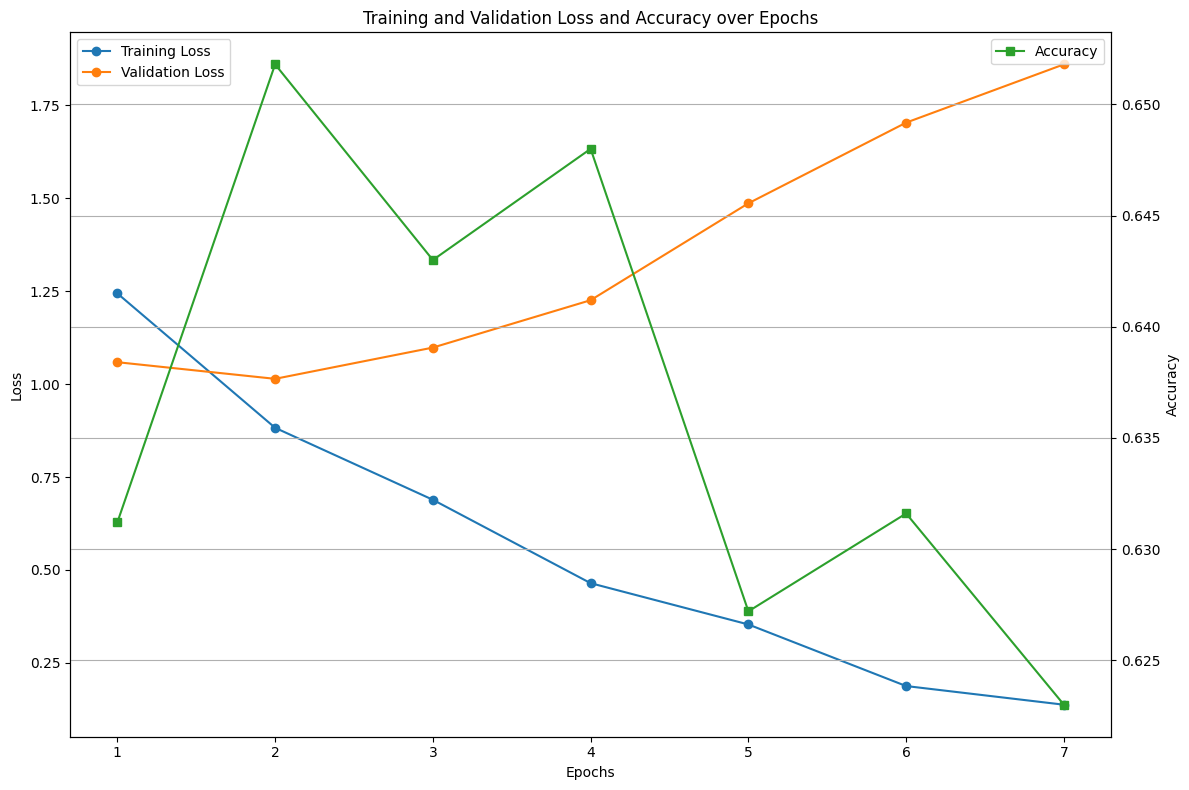

In [52]:
# Provided data
epochs = np.arange(1, 8)
training_loss = [1.244200, 0.882600, 0.688900, 0.464500, 0.353400, 0.187700, 0.137500]
validation_loss = [1.059110, 1.014342, 1.098429, 1.225944, 1.486641, 1.703743, 1.860544]
accuracy = [0.631200, 0.651800, 0.643000, 0.648000, 0.627200, 0.631600, 0.623000]


fig, ax1 = plt.subplots(figsize=(12, 8))

# Ploting Training and Validation Loss on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(epochs, training_loss, 'o-', label='Training Loss', color='tab:blue')
ax1.plot(epochs, validation_loss, 'o-', label='Validation Loss', color='tab:orange')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# y-axis for Accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy')
ax2.plot(epochs, accuracy, 's-', label='Accuracy', color='tab:green')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')


plt.title('Training and Validation Loss and Accuracy over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Evaluation Test data

In [23]:
trainer.evaluate(tokenized_test)

{'eval_loss': 1.0160740613937378,
 'eval_accuracy': 0.6576,
 'eval_runtime': 42.4827,
 'eval_samples_per_second': 117.695,
 'eval_steps_per_second': 3.696,
 'epoch': 7.0}

# Output Prediction examples
We have used random patents to check how our models classify in some random samples that we have gathered just to demonstrate how it predicts. We had prepared a folder 'sampled_patents_data' which contains samples of some patents in .txt format.

In [33]:
import zipfile
zip_file_path = '/content/sample_patents_data.zip'
extract_to_path = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f'Unzipped {zip_file_path} to {extract_to_path}')

Unzipped /content/sample_patents_data.zip to /content/


In [34]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
classify = pipeline(task='text-classification', model=model, tokenizer=tokenizer, device=device)

In [50]:
import glob
import pandas as pd

# Initialize an empty list to collect the data
data = []

# List all files in the sample_patents_data directory
all_files = glob.glob('/content/sample_patents_data/*')

# Ensure there are files to process
if not all_files:
    print("No files found in the directory.")

# Process each file
for file_name in all_files:
    try:
        with open(file_name, 'r') as file:
            content = file.read()
            result = classify(content)
            prediction = result[0]['label']  # Extract the label from the result
            score = result[0]["score"]
            ground_truth = file_name.split('_')[-1].split('.txt')[0]
            # Collect data
            data.append({
                'FileName': file_name,
                'Content': content,
                'Prediction': prediction,
                'GroundTruth': ground_truth,
                'Score': score
            })
    except Exception as e:
        print(f"Error processing file {file_name}: {e}")

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)
df

,FileName,Content,Prediction,GroundTruth,Score
0,/content/sample_patents_data/text4_Human Neces...,a system to generate a representation of a rhy...,Human Necessities,Human Necessities,0.695798
1,/content/sample_patents_data/text1_Physics.txt,an alarm system for a building has a plurality...,Physics,Physics,0.808493
2,/content/sample_patents_data/text3_Chemistry; ...,"a process for producing solid , porous graphit...",Chemistry; Metallurgy,Chemistry; Metallurgy,0.716385
3,/content/sample_patents_data/text5_Performing ...,various embodiments of roller hemming apparatu...,Performing Operations; Transporting,Performing Operations; Transporting,0.773028
4,/content/sample_patents_data/text2_Fixed Const...,"a standardized , corrosion - resistant roof cu...",Fixed Constructions,Fixed Constructions,0.857727
